In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import os

In [4]:
class Network(nn.Module):
    def __init__(self,num_input=2,layers=[64, 64, 64],num_output=3):
        super(Network,self).__init__()
        self.input_layer=nn.Linear(num_input,layers[0])
        self.hidden_layer=nn.ModuleList()
        for i in range(len(layers)-1):
            self.hidden_layer.append(nn.Linear(layers[i],layers[i+1]))
        self.output_layer=nn.Linear(layers[-1],num_output)
    def forward(self,out):
        out=torch.tanh(self.input_layer(out))
        for layer in self.hidden_layer:
            out=torch.tanh(layer(out))
        out=self.output_layer(out)
        return out

In [5]:
class Pinns:
    def __init__(self):
        # Transfer to GPU if it is possible
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network().to(self.device)

        # Assumptions
        self.rho=1.0
        self.nu=0.01
        self.u0=1.0

        # Domain_Definition
        dx=0.01
        dy=0.01
        self.x = torch.arange(0, 1 + dx, dx).to(self.device)
        self.y = torch.arange(0, 1 + dy, dy).to(self.device)
        self.X = torch.stack(torch.meshgrid(self.x,self.y)).reshape(2,-1).T
        self.X.requires_grad = True

        # Boundary_condition
        dx_b=0.001
        dy_b=0.001
        self.x_b = torch.arange(0,1+dx_b,dx_b)
        self.y_b = torch.arange(0,1+dy_b,dy_b)        
        self.X_train = torch.stack(torch.meshgrid(self.x_b,self.y_b[-1])).reshape(2,-1).T
        self.uv_train = torch.stack(torch.meshgrid(self.u0*self.x_b[-1],torch.zeros_like(self.y_b))).reshape(2,-1).T        
        
        # Transfer tensor to GPU
        self.uv_train = self.uv_train.to(self.device)
        self.X_train = self.X_train.to(self.device)
        self.X = self.X.to(self.device)
        
        # Error criterion Definition
        self.criterion = nn.MSELoss()

        # Optimizer setting
        self.adam = torch.optim.Adam(self.network.parameters())

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
        self.network.parameters(),
            lr=0.01,
            max_iter = 2000,
            max_eval = 2000,
            history_size = 50,
            tolerance_grad = 1e-8,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
    # Compute derivatives
    def gradient(self,input,index):
        output = torch.autograd.grad(
            input,
            self.X,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True
        )[0]
        return output[:,index]

    def loss_f(self):
        #Restart Optimizer
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        #output of NN for boundary
        self.uv_P_b = self.network(self.X_train)
        self.u_P_b = self.uv_P_b[:,0]
        
        #loss data definition
        self.loss_data = self.criterion(self.u_P_b,self.uv_train[:,0])
        

        #output of NN
        self.uvp_P = self.network(self.X)
        self.u_P_hat = self.uvp_P[:,0]
        self.v_P_hat= self.uvp_P[:,1]
        self.p_P = self.uvp_P[:,2]

        # Trial function
        x = self.X[:, 0]
        y = self.X[:, 1]
        self.u_P = x * (1 - x) * y * self.u_P_hat
        self.v_P = x * (1 - x) * y * (1 - y) * self.v_P_hat
        #compute derivations
        self.du_dx = self.gradient(self.u_P,0)
        self.du_dy = self.gradient(self.u_P,1)
        self.du_dxx= self.gradient(self.du_dx,0)
        self.du_dyy= self.gradient(self.du_dy,1)
        self.dv_dx = self.gradient(self.v_P,0)
        self.dv_dy = self.gradient(self.v_P,1)
        self.dv_dxx= self.gradient(self.dv_dx,0)
        self.dv_dyy= self.gradient(self.dv_dy,1)
        self.dp_dx = self.gradient(self.p_P,0)
        self.dp_dy = self.gradient(self.p_P,1)

        # compute equation loss
        self.con_equ=self.du_dx+self.dv_dy
        self.u_eqn = self.uvp_P[:,0]*self.du_dx + self.uvp_P[:,1]*self.du_dy + self.dp_dx/self.rho - self.nu*(self.du_dxx + self.du_dyy)
        self.v_eqn = self.uvp_P[:,0]*self.dv_dx + self.uvp_P[:,1]*self.dv_dy + self.dp_dy/self.rho - self.nu*(self.dv_dxx + self.dv_dyy)

        #loss PDE definition
        self.loss_pde = self.criterion(self.con_equ,torch.zeros_like(self.con_equ))+self.criterion(self.u_eqn,torch.zeros_like(self.u_eqn))+\
                        self.criterion(self.v_eqn,torch.zeros_like(self.v_eqn))

        # The total loss is now only the PDE loss, as BCs are enforced mathematically.
        self.loss = self.loss_pde+self.loss_data
        
        self.loss.backward()
        return self.loss
    def train(self, num_epochs=1):
        self.network.train()
        for i in range(num_epochs):
            loss = self.loss_f()
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {self.loss.item():.12f}")
            if i % 1000 == 0:
                torch.save(self.network.state_dict(), r'/home/hossein_vasheghani/saving_model/model_new.pth')
            self.adam.step(self.loss_f)
        self.optimizer.step(self.loss_f)
    def plot(self):
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        self.network.eval()
        with torch.no_grad():
            self.u = self.uvp_P[:,0].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.v = self.uvp_P[:,1].reshape(len(self.x), len(self.y)).cpu().numpy().T
            self.p = self.uvp_P[:,2].reshape(len(self.x), len(self.y)).cpu().numpy().T
        plt.figure(figsize=(10, 8))
        plt.subplot(2, 2, 1)
        contour1 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, levels=50, cmap="jet")
        plt.colorbar(contour1)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("u")
        plt.subplot(2, 2, 2)
        contour2 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.v, levels=50, cmap="jet")
        plt.colorbar(contour2)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("v")
        plt.subplot(2, 2, 3)
        contour3 = plt.contourf(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.p, levels=50, cmap="jet")
        plt.colorbar(contour3)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("pressure")
        plt.figure(figsize=(8, 8))
        plt.subplot(2, 2, 4)
        contour4 = plt.streamplot(self.x.detach().cpu().numpy(), self.y.detach().cpu().numpy(), self.u, self.v, color=self.u, linewidth=2, cmap='autumn')
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title("streamline")
        plt.tight_layout()
        plt.show()

Iteration 0, Loss: 0.820908248425
Iteration 10, Loss: 0.216875359416
Iteration 20, Loss: 0.140392571688
Iteration 30, Loss: 0.115414842963
Iteration 40, Loss: 0.106712803245
Iteration 50, Loss: 0.098279431462
Iteration 60, Loss: 0.089764669538
Iteration 70, Loss: 0.082293979824
Iteration 80, Loss: 0.075790271163
Iteration 90, Loss: 0.069477818906
Iteration 100, Loss: 0.063431009650
Iteration 110, Loss: 0.058568183333
Iteration 120, Loss: 0.055509045720
Iteration 130, Loss: 0.054061312228
Iteration 140, Loss: 0.053247697651
Iteration 150, Loss: 0.052526142448
Iteration 160, Loss: 0.051756143570
Iteration 170, Loss: 0.050943344831
Iteration 180, Loss: 0.050135124475
Iteration 190, Loss: 0.049373049289
Iteration 200, Loss: 0.048687547445
Iteration 210, Loss: 0.048064410686
Iteration 220, Loss: 0.047513373196
Iteration 230, Loss: 0.047041323036
Iteration 240, Loss: 0.046628773212
Iteration 250, Loss: 0.046258486807
Iteration 260, Loss: 0.045917812735
Iteration 270, Loss: 0.045601379126
Ite

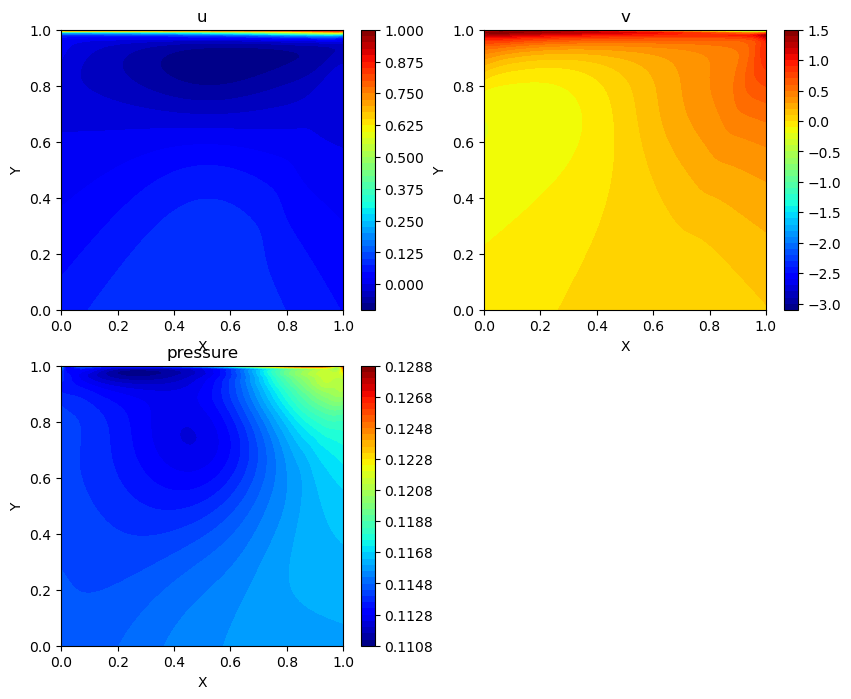

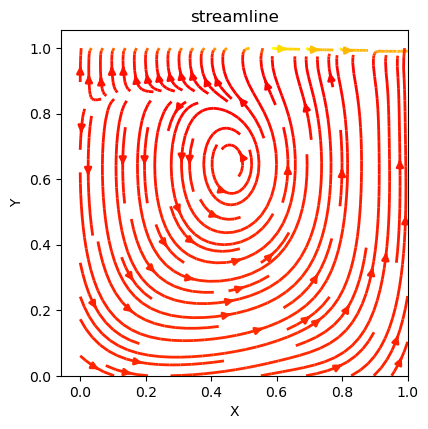

In [7]:
net=Pinns()
net.train(100000)
net.plot()

In [5]:
# Given validation data
x_validation = np.array([1, 8, 9, 10, 14, 23, 37, 59, 65, 80, 95, 110, 123, 124, 125, 126, 129])/129
u_validation2 = np.array([0, -0.03717, -0.04192, -0.04775, -0.06434, -0.1015, -0.15662, -0.21090,
                          -0.20581, -0.13641, 0.00332, 0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1])

y_validation = np.array([1, 9, 10, 11, 13, 21, 30, 31, 65, 104, 111, 117, 122, 123, 124, 125, 129])/129
v_validation2 = np.array([0, 0.09233, 0.10091, 0.10890, 0.12317, 0.16077, 0.17507, 0.17527, 0.05454,
                          -0.24533, -0.22445, -0.16914, -0.10313, -0.08864, -0.07391, -0.05906, 0])

In [ ]:
u=net.uvp_P[:,0]
u=u.reshape(len(net.x), len(net.y)).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
x=torch.arange(0,1+1/128,1/128)
plt.plot(net.x, u[51,:], 'b-', linewidth=2, label='u velocity for PINNs')
plt.plot(x_validation, u_validation2, 'ko', label="u validation", markersize=6, linewidth=2)
plt.xlabel("y")
plt.ylabel("U velocity")
plt.title("U Velocity Profile along the Vertical Centerline (x = 0.5)")
plt.legend()
plt.grid(True)
plt.show()

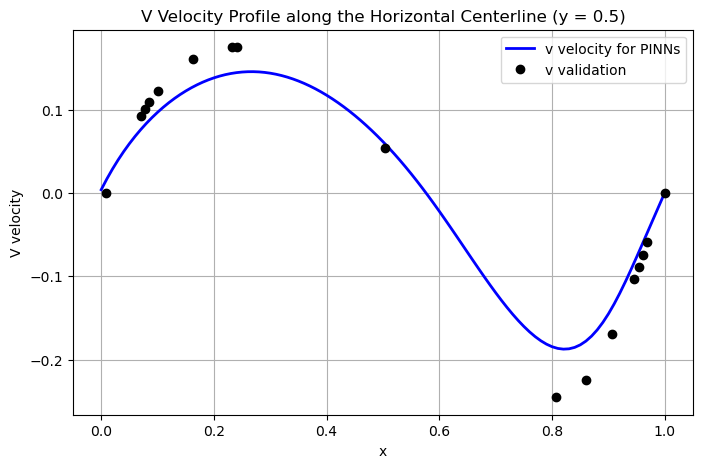

In [12]:
v=net.uvp_P[:,1]
v=v.reshape(len(net.x), len(net.y)).detach().cpu().numpy()
plt.figure(figsize=(8, 5))
x=torch.arange(0,1+1/128,1/128)
plt.plot(net.x, v[:,51], 'b-', linewidth=2, label='v velocity for PINNs')
plt.plot(y_validation, v_validation2, 'ko', label="v validation", markersize=6, linewidth=2)
plt.xlabel("x")
plt.ylabel("V velocity")
plt.title("V Velocity Profile along the Horizontal Centerline (y = 0.5)")
plt.legend()
plt.grid(True)
plt.show()